# Parte (a)

## Seleccionar una marca y obtener los datos:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df = yf.download(
    tickers='TSLA',            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2024-01-01',        # Fecha de inicio
    end='2025-01-01',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df = df.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df['Date'] = pd.to_datetime(df['Date'])

df['Date'] = df['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df.set_index('Date', inplace=True)


df

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume
Date,,,,,,


In [ ]:
pip install alpha_vantage

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Entra a https://www.alphavantage.co/support/#api-key
# Registrate para obtener tu api-key

# Tu clave de API (reemplaza esta por la tuya)
my_key = 'DBM1JY0NQ5V04OZE'   # esta es mía, no la uses o habrá problemas

# Crear objeto TimeSeries
ts = TimeSeries(key=my_key, output_format='pandas')

# Obtener datos diarios de TSLA
ticker = 'TSLA'
data, meta = ts.get_daily(symbol=ticker, outputsize='full')

columnas = [ticker + '_' + i for i in ['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = columnas

inicio = '2024-01-01'
fin = '2025-01-01'
df = data[(data.index >= inicio) & (data.index <= fin)]

df

,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Volume
date,,,,,
2024-12-31,423.79,427.9300,402.5400,403.84,76825121.0
2024-12-30,419.40,427.0000,415.7500,417.41,64941012.0
2024-12-27,449.52,450.0000,426.5000,431.66,82666821.0
2024-12-26,465.16,465.3299,451.0200,454.13,76651210.0
2024-12-24,435.90,462.7800,435.1400,462.28,59551750.0
...,...,...,...,...,...
2024-01-08,236.14,241.2500,235.3000,240.45,85166580.0
2024-01-05,236.86,240.1196,234.9001,237.49,92240035.0
2024-01-04,239.25,242.7000,237.7300,237.93,102629283.0


## Graficar la serie de tiempo:

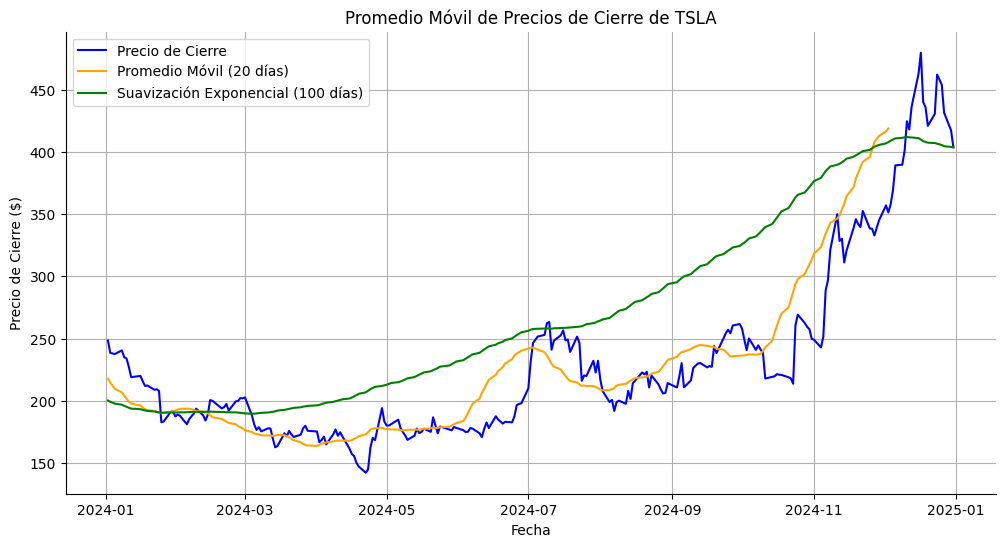

In [ ]:
# Promedio Móvil Simple
ventana_sma = 20
df['SMA'] = df['TSLA_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 100
df['SES'] = df['TSLA_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['TSLA_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de TSLA')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Parte (b)

## Prueba de estacionariedad:

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['TSLA_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -2.4624998753326772
p-value: 0.12486710193332168
La tendencia no es estacionaria (aceptamos la hipótesis nula).


# Parte (c)

## Regresión polinomial:

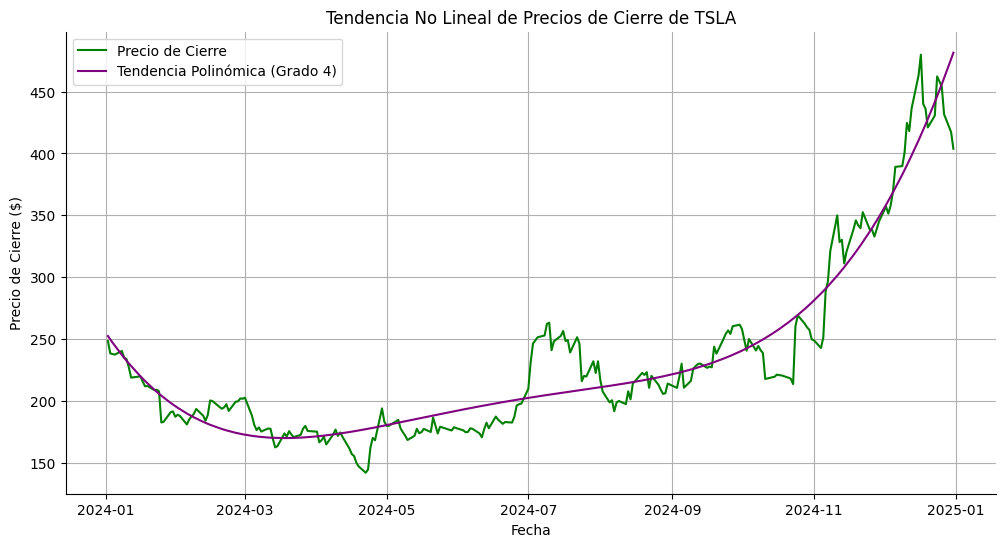

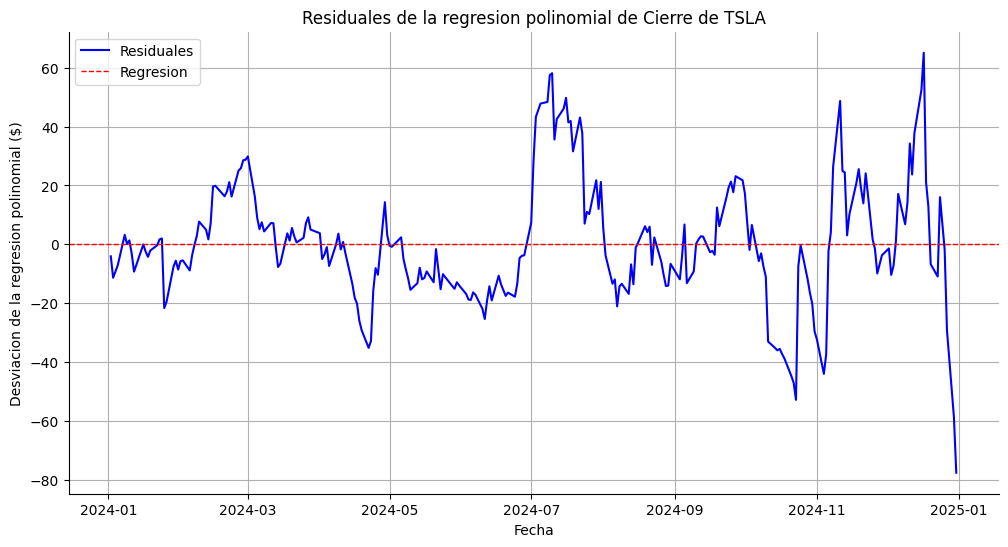

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['TSLA_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 4
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de TSLA') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de TSLA')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Prueba de estacionariedad en los residuales:

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['TSLA_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: -2.4624998753326772
p-value: 0.12486710193332168
La tendencia no es estacionaria (aceptamos la hipótesis nula).
